# Test Systems

Uses REBOUND commit 6fb912f615ca542b670ab591375191d1ed914672

Test trained models on real non-resonant systems

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import rebound
import dask.dataframe as dd
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.style.use('paper.mplstyle')
%matplotlib inline

In [2]:
path = '../data/TTVsystems/KOI-1576/simulation_archives/runs/'

In [3]:
from celmech import Andoyer

def get_k(row):
    sa = rebound.SimulationArchive(path+'sa'+row['runstring'])
    sim = sa[0]
    p2 = sim.particles[2]
    row['h'] = p2.e*np.sin(p2.pomega)
    row['k'] = p2.e*np.cos(p2.pomega)
    avars = Andoyer.from_Simulation(sim, a10=sim.particles[1].a, j=5, k=1, i1=1, i2=2, average=False)
    row['Z12'] = avars.Z
    row['Zcom12'] = avars.Zcom
    avars = Andoyer.from_Simulation(sim, a10=sim.particles[1].a, j=3, k=1, i1=2, i2=3, average=False)
    row['Z23'] = avars.Z
    row['Zcom23'] = avars.Zcom
    return row

In [4]:
trainpath = '../training_data/TTVsystems/KOI-1576/featuresNorbits10000.0Nout80trio/'
labels = pd.read_csv(trainpath + 'labels.csv', index_col=0)
# Create k and h columns for plotting
labels['k'] = 0.
labels['h'] = 0.
labels['Z12'] = 0.
labels['Zcom12'] = 0.
labels['Z23'] = 0.
labels['Zcom23'] = 0.

In [5]:
%%time
dasklabels = dd.from_pandas(labels, npartitions=24)
df = dasklabels.apply(get_k, axis=1, meta=labels).compute(scheduler='processes')

CPU times: user 380 ms, sys: 225 ms, total: 605 ms
Wall time: 1.72 s


In [6]:
def pred(row):
    sa = rebound.SimulationArchive(path+'sa'+row['runstring'])
    sim = sa[0]
    row['probstability'] = model.predict(sim)
    return row

In [7]:
from spock import StabilityClassifier
model = StabilityClassifier()

In [8]:
%%time
df = df.apply(pred, axis=1)

CPU times: user 1h 49min 2s, sys: 4min 4s, total: 1h 53min 6s
Wall time: 20min 12s


In [9]:
%%time
threshold=0.35 # for 10% FPR (fig3.ipynb)
proba = df['probstability'].values
stablemask = df['Stable'] == True
unstablemask = df['Stable'] == False
pstablemask = proba > threshold
punstablemask = proba < threshold

CPU times: user 2.71 ms, sys: 0 ns, total: 2.71 ms
Wall time: 2.61 ms


In [10]:
stablemask.sum()

967

In [11]:
unstablemask.sum()

533

In [12]:
pstablemask.sum()

1392

In [13]:
punstablemask.sum()

108

In [14]:
FPR = 1-(punstablemask & unstablemask).sum()/unstablemask.sum()
FPR

0.8330206378986866

In [15]:
TPR = (pstablemask & stablemask).sum()/stablemask.sum()
TPR

0.9803516028955532

In [16]:
((stablemask & pstablemask).sum() + (unstablemask & punstablemask).sum())/(stablemask.sum() + unstablemask.sum())

0.6913333333333334

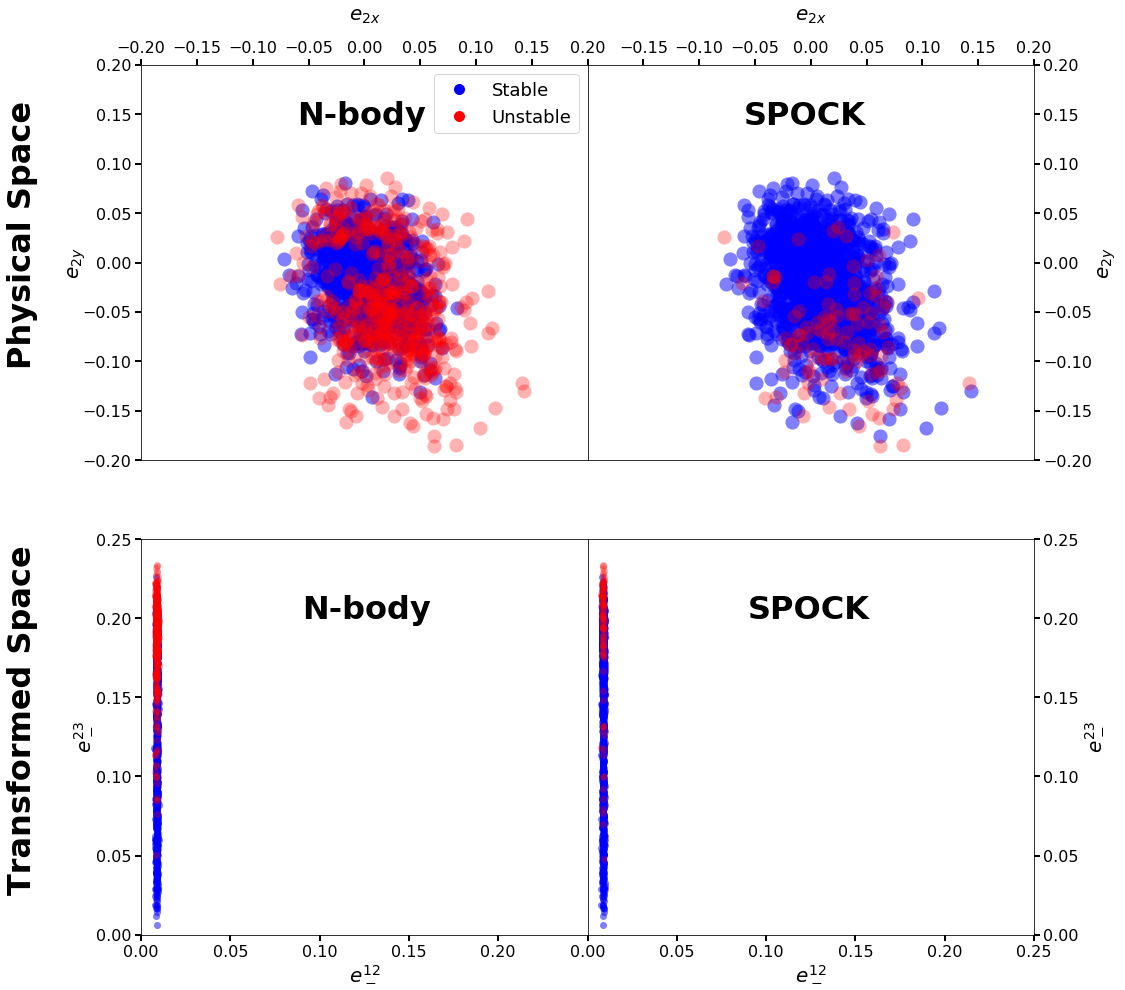

In [31]:
from matplotlib.lines import Line2D

fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=[16, 16])
plt.subplots_adjust(wspace=0)

for ax in axarr.flatten():
    ax.set_rasterization_zorder(1)

s=200
axarr[0,0].scatter(df["k"][stablemask], df["h"][stablemask], c='b', s=s, lw=0, label='Stable', alpha=0.5, zorder=0)
axarr[0,0].scatter(df["k"][unstablemask], df["h"][unstablemask], c='r', s=s, lw=0, label='Unstable', alpha=0.3, zorder=0)
axarr[0,1].scatter(df["k"][pstablemask], df["h"][pstablemask], c='b', s=s, lw=0, label='Stable', alpha=0.5, zorder=0)
axarr[0,1].scatter(df["k"][punstablemask], df["h"][punstablemask], c='r', s=s, lw=0, label='Unstable', alpha=0.3, zorder=0)
axarr[0,1].tick_params(axis='y', which='both', left='off', right='off')
axarr[0,0].text(-0.06, 0.14, 'N-body', weight='bold', size=32)
axarr[0,1].text(-0.06, 0.14, 'SPOCK', weight='bold', size=32)
axarr[0,0].text(-0.32, -0.1, 'Physical Space', weight='bold', size=32, rotation=90)

lim = 0.2
axarr[0,0].set_xlim([-lim, lim])
axarr[0,0].set_ylim([-lim, lim])
axarr[0,1].set_xlim([-lim, lim])
axarr[0,1].set_ylim([-lim, lim])
axarr[0,1].set_xticks([-0.15,-0.1,-0.05,0,0.05,0.1,0.15,0.2])


legend_elements = [Line2D([0], [0], marker='o', lw=0, c='b', markerfacecolor='b', label='Stable', markersize=10),
                   Line2D([0], [0], marker='o', lw=0, c='r', markerfacecolor='r', label='Unstable', markersize=10)]
axarr[0,0].legend(handles=legend_elements, loc='upper right', fontsize=18)

axarr[0,1].yaxis.tick_right()
axarr[0,0].xaxis.tick_top()
axarr[0,1].xaxis.tick_top()


axarr[0,0].set_xlabel(r'$e_{2x}$', labelpad=20)
axarr[0,0].set_ylabel(r'$e_{2y}$', labelpad=-5)
axarr[0,1].set_xlabel(r'$e_{2x}$', labelpad=20)
axarr[0,1].set_ylabel(r'$e_{2y}$')
axarr[0,1].yaxis.set_label_position("right")
axarr[0,0].xaxis.set_label_position("top")
axarr[0,1].xaxis.set_label_position("top")

s=50
axarr[1,0].scatter(df["Z12"][stablemask]*np.sqrt(2), df["Z23"][stablemask]*np.sqrt(2), c='b', s=s, lw=0, label='Stable', alpha=0.5, zorder=0)
axarr[1,0].scatter(df["Z12"][unstablemask]*np.sqrt(2), df["Z23"][unstablemask]*np.sqrt(2), c='r', s=s, lw=0, label='Unstable', alpha=0.3, zorder=0)
axarr[1,1].scatter(df["Z12"][pstablemask]*np.sqrt(2), df["Z23"][pstablemask]*np.sqrt(2), c='b', s=s, lw=0, label='Stable', alpha=0.5, zorder=0)
axarr[1,1].scatter(df["Z12"][punstablemask]*np.sqrt(2), df["Z23"][punstablemask]*np.sqrt(2), c='r', s=s, lw=0, label='Unstable', alpha=0.3, zorder=0)
axarr[1,1].tick_params(axis='y', which='both', left='off', right='off')
axarr[1,0].text(0.09, 0.2, 'N-body', weight='bold', size=32)
axarr[1,1].text(0.09, 0.2, 'SPOCK', weight='bold', size=32)
axarr[1,0].text(-0.075, 0.03, 'Transformed Space', weight='bold', size=32, rotation=90)

xlim=0.25
ylim=0.25
axarr[1,0].set_xlim([0, xlim])
axarr[1,0].set_ylim([0, ylim])
axarr[1,1].set_xlim([0, xlim])
axarr[1,1].set_ylim([0, ylim])
axarr[1,0].set_xticks([0, 0.05, 0.1, 0.15, 0.2])
#axarr[1,0].set_yticks([0, 0.1, 0.2])
axarr[1,1].set_xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25])
#axarr[1,1].set_yticks([0, 0.1, 0.2])
axarr[1,1].yaxis.tick_right()
axarr[1,1].yaxis.set_label_position("right")

axarr[1,0].set_xlabel(r'$e_-^{12}$')
axarr[1,0].set_ylabel(r'$e_-^{23}$')
axarr[1,1].set_xlabel(r'$e_-^{12}$')
axarr[1,1].set_ylabel(r'$e_-^{23}$')

fig.savefig('KOI1576.pdf', bbox_inches='tight')